# Logistic Regression

This notebook is a spam filter based off of a logistic regression model.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve, auc

np.random.seed(seed=0)
%matplotlib inline

### Load Data

In [2]:
# Load Data

email = pd.read_csv("email.csv")

email.head()
email.tail()
print(email.columns.values)

email.fillna("n", inplace=True)

for em in email["Subject"].tolist():
    if not isinstance(em, str):
        print(em)

len(email)

['Subject' 'Body' 'From: (Name)' 'From: (Address)' 'From: (Type)'
 'Importance' 'type']


495

### Bags of Words

As we are working with text data, and models are unable to work with strings as input data, we need to convert them to numbers. Bags of Words will allow us to count and vectorize all words in a given set, then transform the strings into series of numbers that represent the words for the model to work with.

In [3]:
# Bags of Words

corpus = {}

for col in email.columns.values:
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(email[col]).todense()
    corpus[col] = features

print(corpus.keys())

# Term Frequency times Inverse Document Frequenct (tf-idf)

corpus_tfidf = {}
for col in email.columns.values:
    tfidf_transformer = TfidfTransformer()
    corpus_tfidf[col] = tfidf_transformer.fit_transform(corpus[col]).todense()
    print(corpus_tfidf[col].shape)

dict_keys(['Subject', 'Body', 'From: (Name)', 'From: (Address)', 'From: (Type)', 'Importance', 'type'])
(495, 1093)
(495, 13318)
(495, 444)
(495, 555)
(495, 1)
(495, 1)
(495, 2)


### Splitting Features

Here the desired features are split into separate dataframes. This is because each feature, when converted to bags of words, is a matrix of the features and their bags of words. Creating a dataframe where each element is a matrix is impossible, so to get around this I am splitting each desired feature into its own dataframe, and as necessary concatenating dataframes to combine features.

In [4]:
subject = pd.DataFrame(corpus_tfidf["Subject"])

body = pd.DataFrame(corpus_tfidf["Body"])

fromname = pd.DataFrame(corpus_tfidf["From: (Name)"])

fromaddress = pd.DataFrame(corpus_tfidf["From: (Address)"])

fromtype = pd.DataFrame(corpus_tfidf["From: (Type)"])

spam = pd.DataFrame(corpus_tfidf["type"])
spam = spam[1]

### Multinomial Naive Bayes Model

In [5]:
def logisticregression(x, y):
    """
    
    This function performs the required functions for fitting and prediction a Logistic Regression model
    from given x and y datasets.
    
    Args:
        x (array-like): independent data
        y (array-like): target data
        
    Return:
        score (float): Mean accuracy of the model on the given test and target data
    
    """
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 0)
    
    # Fit and predict model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    predicted = logreg.predict(X_test)
    predicted
    
    logreg.predict(X_test)
    score = logreg.score(X_test, y_test)
    
    # Plot
#     x_axis = range(len(X_test))

#     fig,ax = plt.subplots(figsize=(15,10))
#     ax.scatter(x_axis, predicted, alpha = 0.3)
#     ax.scatter(x_axis, y_test, alpha = 0.3)
    
    return score

### Results

Below is the model run for each feature-set, with the accuracy score printed and a scatter plot of each prediction vs test point.

In [6]:
subjectscore = logisticregression(subject, spam)
print("Model Mean Accuracy [Subject]:", subjectscore)

bodyscore = logisticregression(body, spam)
print("\nModel Mean Accuracy [Body]:", bodyscore)

fnamescore = logisticregression(fromname, spam)
print("\nModel Mean Accuracy [From Name]:", fnamescore)

faddscore = logisticregression(fromaddress, spam)
print("\nModel Mean Accuracy [From Address]:", faddscore)

ftypescore = logisticregression(fromtype, spam)
print("\nModel Mean Accuracy [From Type]:", ftypescore)

subbodscore = logisticregression(pd.concat([subject, body], axis=1), spam)
print("\nModel Mean Accuracy [Subject + Body]:", subbodscore)

subbodfnamescore = logisticregression(pd.concat([subject, body, fromname], axis=1), spam)
print("\nModel Mean Accuracy [Subject + Body + From Name]:", subbodfnamescore)

subbodfaddscore = logisticregression(pd.concat([subject, body, fromaddress], axis=1), spam)
print("\nModel Mean Accuracy [Subject + Body + From Address]:", subbodfaddscore)


Model Mean Accuracy [Subject]: 0.756097560976

Model Mean Accuracy [Body]: 0.841463414634

Model Mean Accuracy [From Name]: 0.823170731707

Model Mean Accuracy [From Address]: 0.841463414634

Model Mean Accuracy [From Type]: 0.689024390244

Model Mean Accuracy [Subject + Body]: 0.908536585366

Model Mean Accuracy [Subject + Body + From Name]: 0.90243902439

Model Mean Accuracy [Subject + Body + From Address]: 0.896341463415


### ROC Curve

In [8]:
# Compute ROC curve and ROC area for best model

# Need the y_test data and prediction probabilities
X_train, X_test, y_train, y_test = train_test_split(pd.concat([subject, body], axis=1), spam,
                                                               test_size = 0.33, random_state = 0)

# Fit and get prediction probabilities
logreg = LogisticRegression()
predict_prob = logreg.fit(X_train, y_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, predict_prob[:,1])
roc_auc = auc(fpr, tpr)

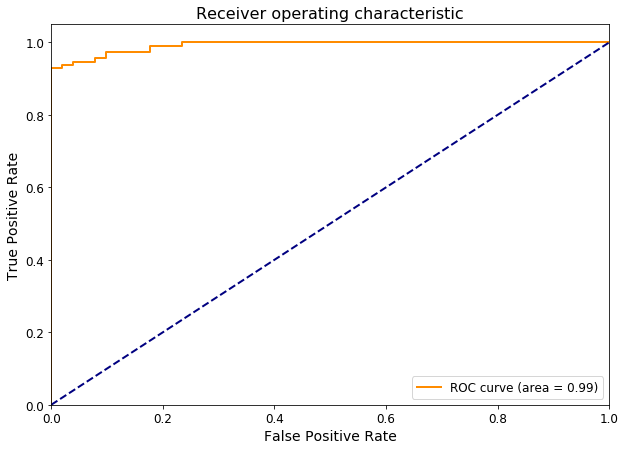

In [15]:
fig,ax = plt.subplots(figsize=(10,7))
lw = 2
ax.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver operating characteristic', fontsize=16)
ax.legend(loc="lower right", fontsize=12)
ax.tick_params(axis="both", labelsize=12)